# Imports and Constants

In [2]:
import numpy as np
import pandas as pd
import sklearn
import random
import os

from savingOutputs import *
from loadData import *
from masks import *
from decoding import *
from plots import *

In [3]:
SEED = 0
random.seed(SEED)
classes = ['Up', 'Down', 'Right', 'Left']
nb_runs = 12
length = nb_runs * len(classes)
subjects_ids = range(1, 2)  # TODO modify this to get all subjects (here we only have 1 for the example)
n_subjects = len(subjects_ids)
n_perms = 1000
class_labels = [""] * (2 * length)
for i in range(length * 2):
    class_labels[i] = classes[(i // nb_runs) % len(classes)]
labels = dict()
labels["vis"] = np.array(class_labels[:length])
labels["aud"] = np.array(class_labels[length:])

classical_tasks_regions = [(["vis"], ["V5_R", "V5_L"]),
                           (["aud"], ["PT_R", "PT_L"]),
                           (["aud"], ["V5_R", "V5_L"])]

cross_modal_task_regions = [(["vis", "aud"], ["V5_R", "V5_L"])]

classifier = sklearn.svm.SVC(C=1, random_state=SEED)  # default parameters, there is clearly improvements to be
# made here
decoder = Decoder(n_perm=n_perms, model=classifier, n_classes=len(classes), n_splits=nb_runs, seed=SEED)

# Loading data and decoding

In [4]:
cv_scores = [dict() for _ in subjects_ids]
p_values = [dict() for _ in subjects_ids]
scores_perms = [dict() for _ in subjects_ids]
maps_masked = [dict() for _ in subjects_ids]

Loading done for subject 1/1


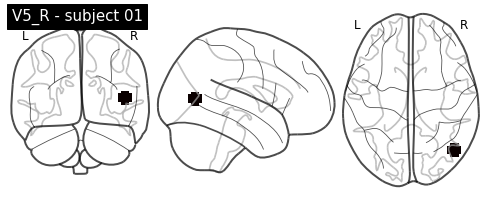

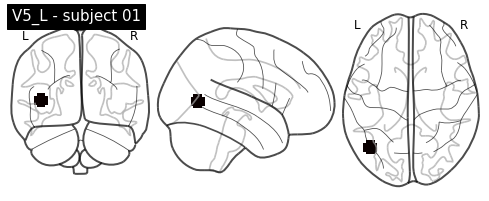

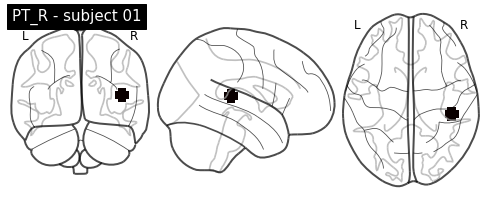

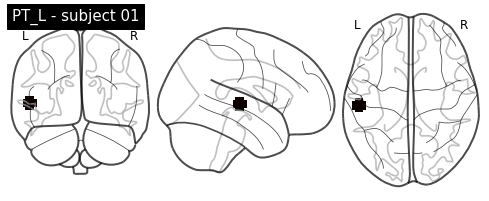

In [5]:
for i, subj_id in enumerate(subjects_ids):
    t_maps, beta_maps = get_maps([subj_id])
    masks = get_masks([subj_id], plot=True)
    maps = apply_mask_to_maps(t_maps, masks)
    maps_masked[i]["vis"] = get_part_of_maps(maps, 0, length)  # maps acquired for the vision experiment
    maps_masked[i]["aud"] = get_part_of_maps(maps, length, 2 * length)  # maps acquired for the audition experiment
    del t_maps ; del beta_maps ; del masks  # to relieve memory
    print("Loading done for subject "+str(subj_id)+"/"+str(n_subjects))

In [6]:
for i, subj_id in enumerate(subjects_ids):
    # classical decoding : training on a task and decoding on other samples from same task
    for tasks, regions in classical_tasks_regions:
        cv_sc, p_val, scores_perm = decoder.classify_tasks_regions(maps_masked[i], labels, tasks, regions)
        cv_scores[i].update(cv_sc)
        p_values[i].update(p_val)
        scores_perms[i].update(scores_perm)
    print("Classical decoding done for subject "+str(subj_id)+"/"+str(n_subjects))

    # cross-modal decoding : training on a task and decoding on samples from another task
    for tasks, regions in cross_modal_task_regions:
        scores_cross_mod = decoder.cross_modal_decoding(maps_masked[i], labels, tasks, regions)
        cv_scores[i].update(scores_cross_mod)

    print("Cross-modal decoding done for subject "+str(subj_id)+"/"+str(n_subjects))

Classical decoding done for subject 1/1
Cross-modal decoding done for subject 1/1


# Saving results

In [8]:
create_outputs_directory()
save_dicts("cv_scores.csv", cv_scores, list(cv_scores[0].keys()), subjects_ids)
save_dicts("p_values.csv", p_values, list(p_values[0].keys()), subjects_ids)
save_dicts_perms("scores_perms.csv", scores_perms, subjects_ids)

# Plotting results

In [9]:

plt_directory = "plots"
if not os.path.exists(plt_directory): os.makedirs(plt_directory)

plt = Plotter(plt_directory, subjects_ids)
plt.plot_cv_scores("out/cv_scores.csv")
plt.plot_p_values("out/p_values.csv")
plt.plot_perms_scores("out/perms_scores.csv", n_perms)